In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Simulator

The SEM simulator 4 building blocks: _nodes, edges, graphs, parameterizers_

1. _nodes_ defined by i) name, ii) parents, iii) state funtion, iv) output function
2. _edges_ defined by i) parent-child node pair; ii) edge function.
3. _graphs_ defined by its set of nodes and edges (via an adjacency matrix)
4. Functions require paremters (e.g. coefficients of a linear state function). _Parameterizers_ generate a set of simulation parameters at each run. Via parameterizers, we apply simulation partial-restrictions, while randomizing the rest (e.g. generate normally distributed data via any linear model coefficients, or treatment interactions with any arbitrary edge function) 

## Nodes

Create a source node:

In [26]:
from rad_sim.sem.graph_objects import Node

# instantiate
n1 = Node(name='X1', parents=[])
# set output function (dtype)
n1.set_output_function(
    function_name='gaussian_noise'
).set_output_params(
    params={'rho': 0}
)
# sample: size is determined because it's source node
n1.calc_state(size=1000)
n1.calc_output()

data = pd.DataFrame({'X1': n1.value['output']})
# printing first 5 rows
data.head()

,X1
0,0.463500
1,-0.918925
2,-0.483116
3,-1.986624
4,0.400972


In [19]:
# instantiate
n2 = Node(name='X2', parents=['X1'])
# set state function
n2.set_state_function(
    function_name='linear'
).set_state_params(
    params={'coefs':[1.5]}
)
# set output function (dtype)
n2.set_output_function(
    function_name='bernoulli'
).set_output_params(
    params={'gamma': 1, 'rho':0}
)
# sample: size is determined because it's source node
n2.calc_state(inputs=data)
n2.calc_output()

data['X2'] = n2.value['output']
# printing first 5 rows
data.head()

,X1,X2
0,0.816880,0
1,-0.222590,1
2,-0.486934,0
3,-1.519365,0
4,-0.314446,0


visualize (for the fun of it)

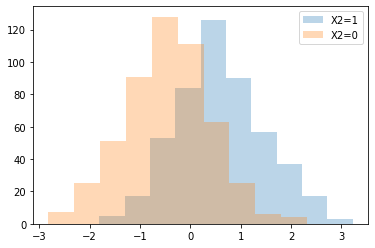

In [20]:
plt.hist(data[data.X2==1].X1, alpha=0.3, label='X2=1')
plt.hist(data[data.X2==0].X1, alpha=0.3, label='X2=0')
plt.legend()
plt.show()

## Edges

create and edge between `X1` and `X2`: output of `X1` passes through edge before going to `X2`

In [21]:
from rad_sim.sem.graph_objects import Edge

# instantitate
e1 = Edge(parent='X1', child='X2')
# set function and params
e1.set_function(
    function_name='sigmoid'
).set_function_params(
    function_params={'alpha': 1, 'beta': 1.9, 'gamma': 1, 'tau': 1, 'rho': 0}
)
# map
edge_output = e1.map(array=data['X1'])

# give this as the input to X2
n2.calc_state(
    inputs=pd.DataFrame({'X1': edge_output})
)
data['X2'] = n2.calc_output()

plot histogram again

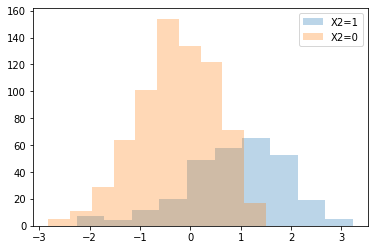

In [22]:
plt.hist(data[data.X2==1].X1, alpha=0.3, label='X2=1')
plt.hist(data[data.X2==0].X1, alpha=0.3, label='X2=0')
plt.legend()
plt.show()

## Graphs and parameterizers

Graphs simulate nodes and edges given an adjacency matrix and the set of parameters

In [23]:
from rad_sim.sem.graph_objects import BaseGraph

graph = BaseGraph()
graph.set_nodes(nodes_list=[
    {
        'name': 'A1',
        'parents': [],
        'output_type': 'continuous',
        'state_function': 'linear',
        'output_function': 'gaussian_noise',
        'state_params': {},
        'output_params': {'rho': 0.02}
    },
    {
        'name': 'A2',
        'parents': [],
        'output_type': 'continuous',
        'state_function': 'linear',
        'output_function': 'gaussian_noise',
        'state_params': {},
        'output_params': {'rho': 0.02}
    },
    {
        'name': 'B1',
        'parents': ['A1', 'A2'],
        'output_type': 'binary',
        'state_function': 'linear',
        'output_function': 'bernoulli',
        'state_params': {'coefs': np.array([1, 1])},
        'output_params': {'rho': 0.02, 'gamma': 0}
    }
])
edge_param = {'alpha': 1, 'beta': 0, 'gamma': 0, 'tau': 1, 'rho': 0.02}
graph.set_edges(
    adj_matrix=pd.DataFrame(
        [
            [0, 0, 1],
            [0, 0, 1],
            [0, 0, 0]
        ],
        columns=['A1', 'A2', 'B1'],
        index=['A1', 'A2', 'B1']
    ),
    function_specs={
        'A1 -> B1': {'function_name': 'sigmoid', 'function_params': edge_param},
        'A2 -> B1': {'function_name': 'sigmoid', 'function_params': edge_param}
    }
)
data = graph.sample(size=300)
print(data)

           A1        A2  B1
0   -1.276494  2.310781   1
1   -0.552610 -1.184648   0
2    0.709854  0.089922   1
3    0.979707  0.980596   1
4   -0.927297  0.880360   0
..        ...       ...  ..
295 -0.102151 -0.644829   0
296  1.113315 -0.026888   1
297  1.099776  0.404191   1
298 -0.194144 -1.520580   0
299 -0.336262 -0.876295   0

[300 rows x 3 columns]


randomizers can be used to defined different scenarios (a desired part is fixed, rest is randomized.) a look at the yaml file:

```
node:
  state:
    linear:
      coefs: [0, 3]
    poly1_interactions:
      coefs: [0, 3]
  output:
    gaussian_noise:
      rho: [0, 0.05]
    gamma_noise:
      rho: [0, 0.05]
    bernoulli:
      mean_: [0.1, 0.9]
      gamma: 0, 1
      rho: [0.01, 0.07]
edge:
  sigmoid:
    alpha: [1, 6]
    beta: [-0.8, 0.8]
    tau: 1, 3, 5
    rho: [0.05, 0.2]
  gaussian_rbf:
    alpha: [1, 6]
    beta: [-0.8, 0.8]
    tau: 1, 3, 5
    rho: [0.05, 0.2]
  beta_noise:
    rho: [0.05, 0.3]
```

## remarks

- for source nodes, standard gaussian normal is sampled from.
- state functions: _linear, linear+interactions_.
- output functions: _continuous with Gaussian noise, bernoulli_. any type of data can be simulated using state value
- edge functions are: _identity (no change), sigmoid and Gaussian RBF (for continuous input), Beta noise (for binary input)_

## remarks

- for source nodes, standard gaussian normal is sampled from.
- state functions: _linear, linear+interactions_.
- output functions: _continuous with Gaussian noise, bernoulli_. any type of data can be simulated using state value
- edge functions are: _identity (no change), sigmoid and Gaussian RBF (for continuous input), Beta noise (for binary input)_

# Mapping Functions

##  Edge Function

### No-noise equations

$$
A_{ij} = \mathcal{E}_{ij}(\tilde{V}_i)
$$

Identity function

$$
\mathcal{E}(x) = x
$$

Sigmoid:

$$
\mathcal{E}(x; \gamma, \alpha, \beta) := \frac{1}{ 1 + \exp\Big(-1^\gamma . 2\alpha(x-\beta)\Big) }
$$

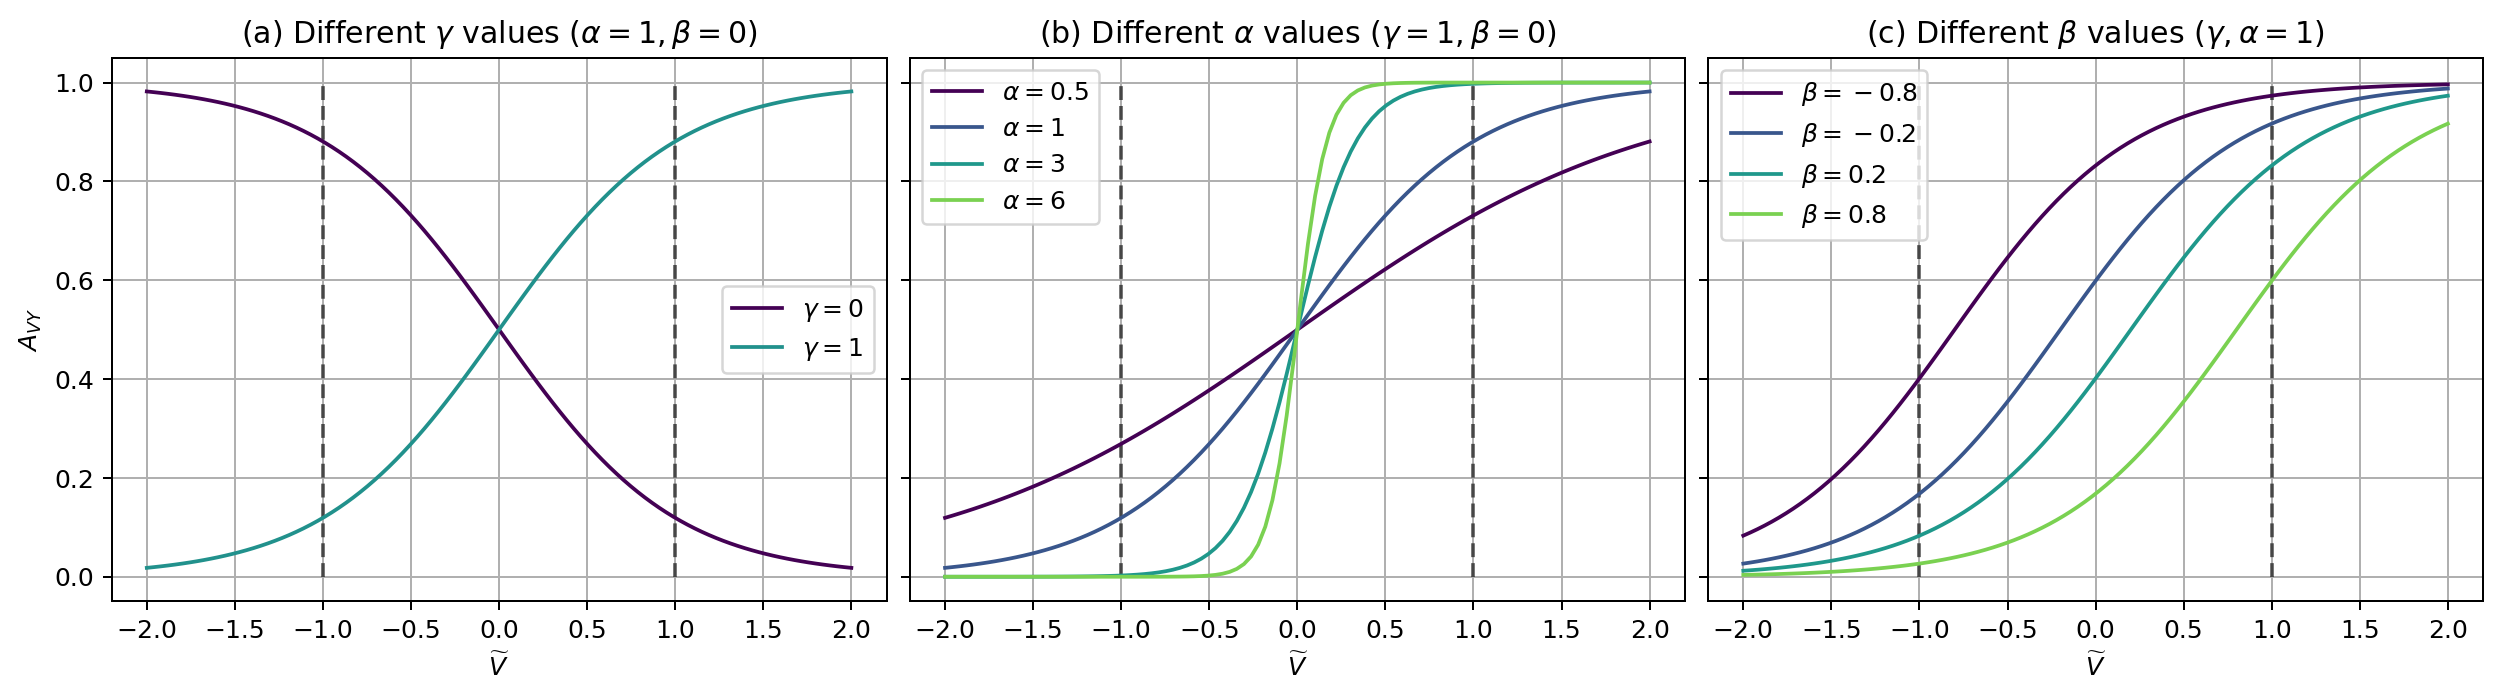

Gaussian RBF:

$$
\mathcal{E}(x; \gamma, \alpha, \beta) = \gamma + -1^\gamma \exp{\big(-\alpha(x-\beta)^2\big)}
$$

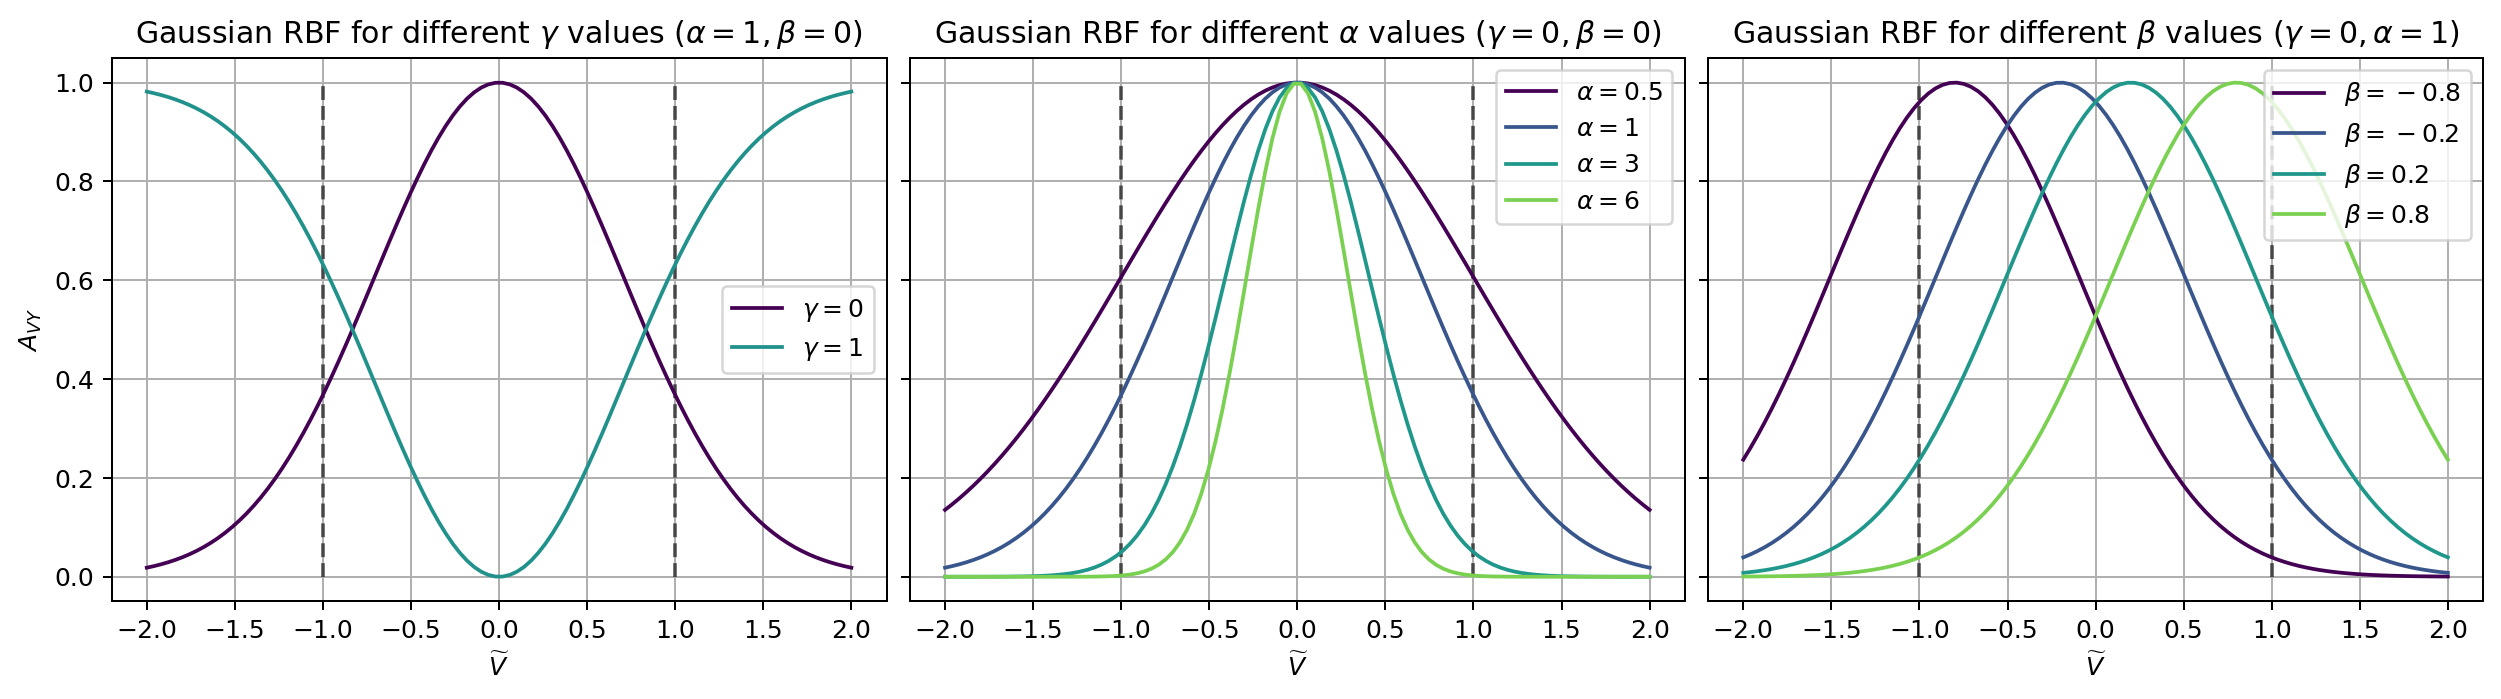

### Noise option

The edge output is subjected to noise:

- for Identity function: gaussian noise is an option
- for $[0,1]$-scaled: input of the edge function can be applied to noise
- for binary input edges, we can use the following noise profile: Beta (for binary input)

$$
\mathcal{E}(x) = x + \epsilon(x;p), \quad \epsilon(x; B, \rho) \sim \begin{cases}
    \text{Beta}(1, B-(B-1)\rho) & x = 0 \\
    \text{Beta}(B-(B-1)\rho, 1)-1 & x = 1
\end{cases}
$$

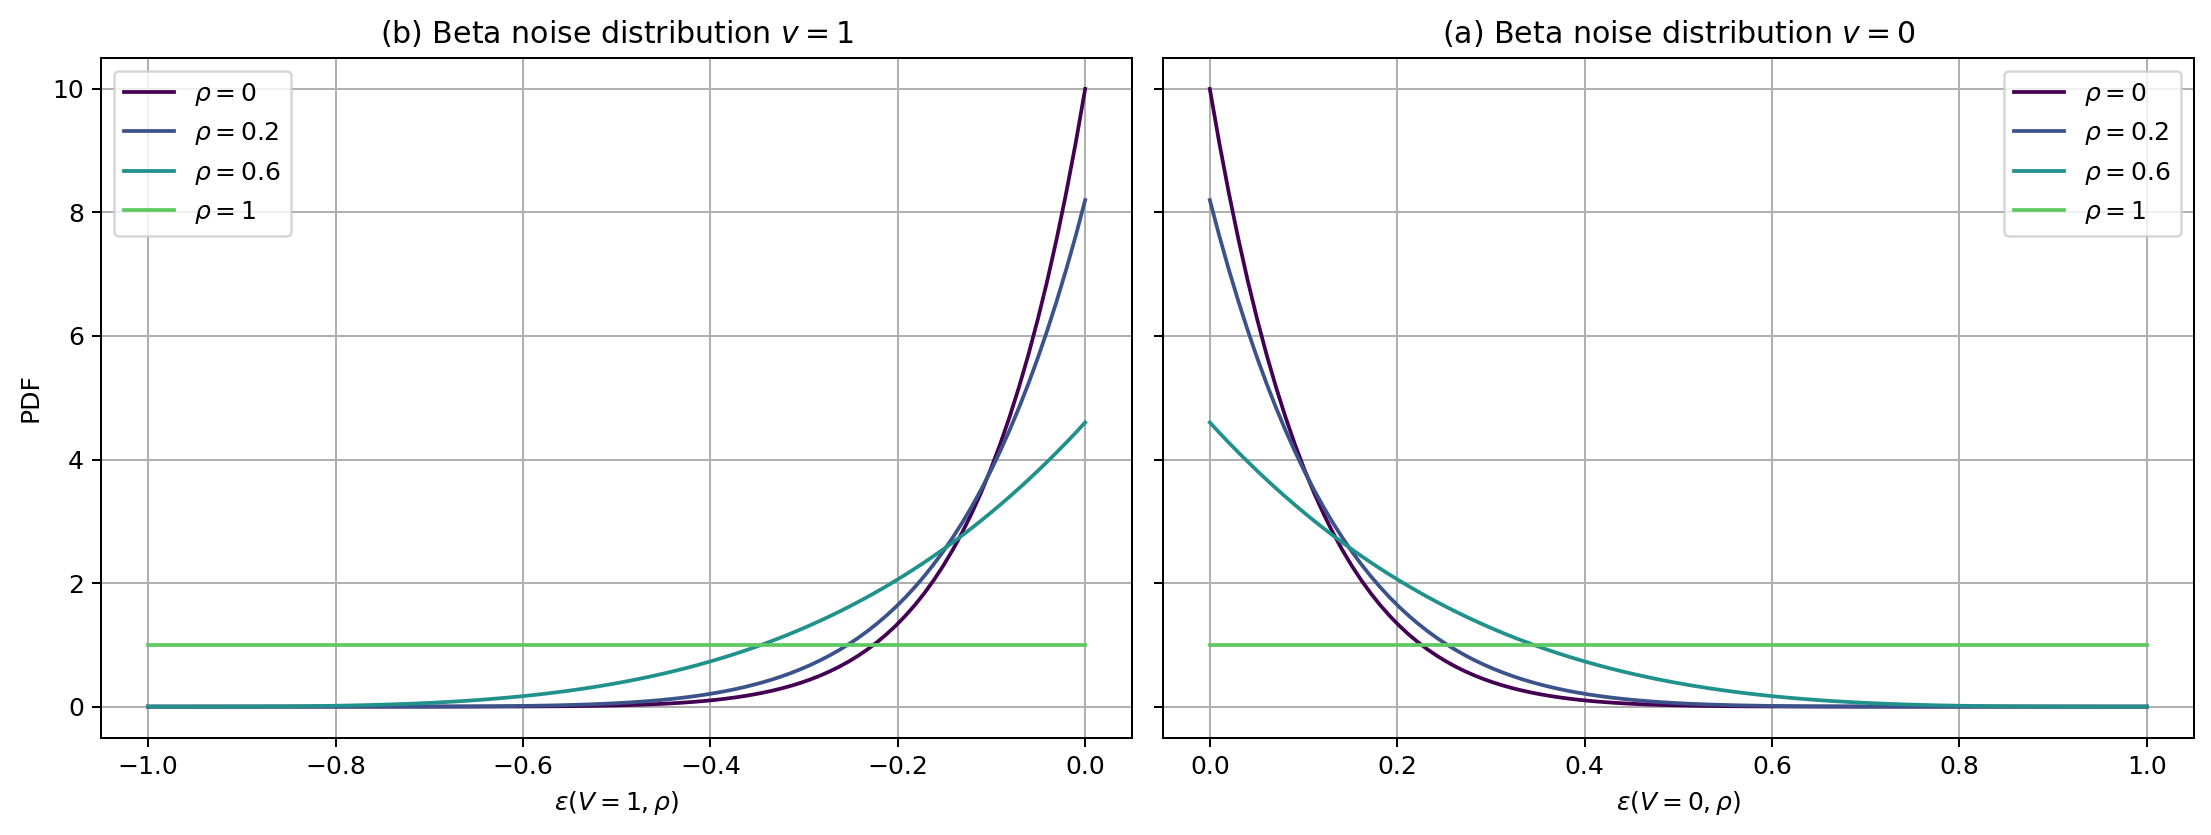

_intuition behind beta noise_: suppose one of the following possibilities,

$$
E[X_2 | X_1 = 0 ] = \alpha E[X_2 | X_1 = 1 ] + \beta \\
X_2 | X_1 = 0 \sim \text{Dist}(\omega_0, ..., \omega_p), \quad X_2 | X_1 = 1 \sim \text{Dist}(\omega'_0, ..., \omega'_p)
$$

we need to think about one of the probabilistic interpretations and model it.

#### option: probabilistic model parameters

Uncertainty can be applied to the model parameters (parameters of a function is sampled from a distribution)

## State Functions

- Linear (w; w/o interactions)
- NN
- ...


both noise options are applicable 

## Output Functions

Output functions determine the data type, so any output function we can have:

- for continuous: $\sim \mathcal{N}(\mu, \sigma)$
- for binary: $\sim \text{Bern}(\mu)$
- for time-to-event: cox model
- ...

This is the definition of _hard intervention_ in causal inference

# Challenge of soft intervention

We need _soft intervention_ implementation for missing data simulation. how do we do it?

**solution:** parents can contribute to both different model parameters.

binary/discrete parents are good candidate to apply soft intervention (then we can get rid of the noise profile)